import modules

In [1]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence, dist, dim_specific_MSE, dim_specific_dist, distV2
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


set device

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate dataset

In [3]:
grid = t.zeros((2, 30, 30), device=device)
grid[:] = 50
grid[0, 12:17] = 90

gamma = 0.005
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 100
num_steps = 1_000
DA = 0.1
DB = 0.4

sequence = generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
)
dataset = chop_and_shuffle_data(sequence, shuffle=True)
if device == "cuda":
    dataset.cuda()
print(f"created dataset with shape: {dataset.shape}")


  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:06<00:00, 156.61it/s]

created dataset with shape: torch.Size([999, 2, 2, 30, 30])


visualize the gradient of k1 when varying k1_bar

In [4]:
# we use the original DA and DB values
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
# split the dataset for usage
X = dataset[:,0]
Y_obs = dataset[:,1]
# rate coefficient ranges
k1_vals = t.linspace(0.0001, 0.9999, 100)
k1_bar_vals = t.linspace(0.0001, 0.9999, 100)

# we use the original rate coefficients for the other reaction channels
k2 = t.tensor(0.1, device=device)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)

distances = []
with t.no_grad():
    # iterate over the DB values
    for k1 in k1_vals:
        # iterate over the DA values
        for k1_bar in tqdm(k1_bar_vals):
            # collect the results of the current test run
            distances_current_run = []
            # For each DA value, we simulate and backpropagate 2 times,
            # averaging the distance and the gradient of each run
            for run in range(5):
                # 1. run the diffusion step on each sample
                diffused_samples = diffuse_STE(X, N, DA, DB)
                # 2. run the reaction step on each sample
                Y_sim = rho_STE(diffused_samples, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
                # use the sum of dim-specific distances
                dist_val = distV2(X, Y_sim, Y_obs)
                distances_current_run.append(dist_val.detach().cpu().numpy())
            distances.append(np.mean(distances_current_run))

100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


In [12]:
# we use the original DA and DB values
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
# split the dataset for usage
X = dataset[:,0]
Y_obs = dataset[:,1]
# rate coefficient ranges
k1_vals = t.linspace(0.0001, 0.9999, 10)
k1_bar_vals = t.linspace(0.0001, 0.9999, 10)

# we use the original rate coefficients for the other reaction channels
k2 = t.tensor(0.1, device=device)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)


# collect the results of each test run here
grad_means_k1 = []
grad_means_k1_bar = []
distances = []
# iterate over the DB values
for k1 in tqdm(k1_vals):
    # iterate over the DA values
    for k1_bar in k1_bar_vals:
        # collect the results of the current test run
        distances_current_run = []
        grad_k1_current_run = []
        grad_k1_bar_current_run = []
        # For each DA value, we simulate and backpropagate 2 times,
        # averaging the distance and the gradient of each run
        for run in range(10):
            k1.requires_grad_()
            k1_bar.requires_grad_()
            # 1. run the diffusion step on each sample
            diffused_samples = diffuse_STE(X, N, DA, DB)
            # 2. run the reaction step on each sample
            Y_sim = rho_STE(diffused_samples, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
            # use the sum of dim-specific distances
            dist_val = distV2(X, Y_sim, Y_obs)
            distances_current_run.append(dist_val.detach().cpu().numpy())
            grad_k1, grad_k1_bar = t.autograd.grad(dist_val, (k1, k1_bar))
            grad_k1_current_run.append(grad_k1.detach().cpu().numpy())
            grad_k1_bar_current_run.append(grad_k1_bar.detach().cpu().numpy())
        distances.append(np.mean(distances_current_run))
        grad_means_k1.append(np.mean(grad_k1_current_run))
        grad_means_k1_bar.append(np.mean(grad_k1_bar_current_run))

100%|██████████| 10/10 [08:44<00:00, 52.41s/it]


<Figure size 640x480 with 0 Axes>

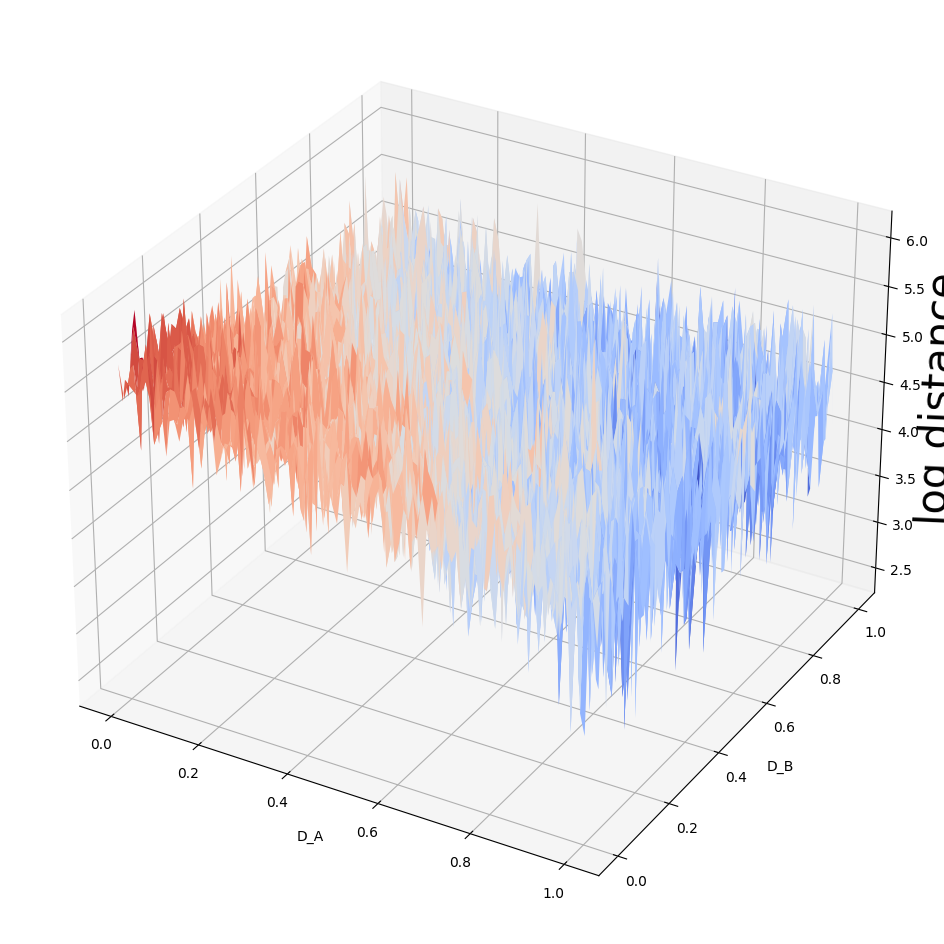

<Figure size 640x480 with 0 Axes>

In [7]:
from matplotlib import cm
from matplotlib import rcParams

grid_k1, grid_k1_bar = t.meshgrid(k1_vals, k1_bar_vals, indexing="ij")

fig, ax = plt.subplots(subplot_kw={"projection": "3d", "computed_zorder": False}, figsize=(12,12))
ax.plot_surface(grid_k1.cpu(), grid_k1_bar.cpu(), np.log(np.array(distances)).reshape(100,100), cmap=cm.coolwarm)
ax.set(xlabel="D_A", ylabel="D_B") 
ax.set_zlabel('log distance', fontsize=30, rotation = 0, position=(10,10))

plt.figure(constrained_layout=True)

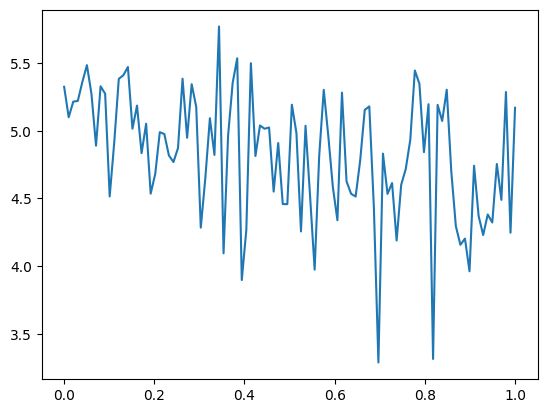

In [14]:
#plt.plot(k1_bar_vals.cpu(), np.log(np.array(distances[:100])))
#plt.plot(k1_bar_vals.cpu(), np.log(np.array(distances[900:1000])))
#plt.plot(k1_bar_vals.cpu(), np.log(np.array(distances[1900:2000])))
#plt.plot(k1_bar_vals.cpu(), np.log(np.array(distances[2900:3000])))
plt.plot(k1_bar_vals.cpu(), np.log(np.array(distances[3900:4000])))

In [8]:
np.array(distances).shape

(10000,)

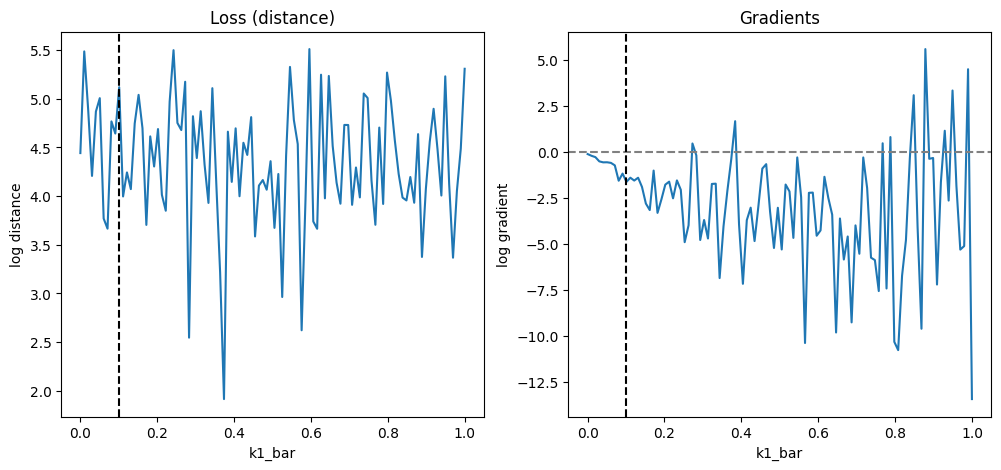

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].plot(k1_bar_vals.cpu(), np.log(np.array(distances[-100:])))
axs[1].plot(k1_bar_vals.cpu(), np.array(grad_means_k1_bar[-100:]))

axs[0].set(title="Loss (distance)", xlabel="k1_bar", ylabel="log distance")
axs[1].set(title="Gradients", xlabel="k1_bar", ylabel="log gradient")

axs[0].axvline(0.1, color='black', linestyle="--", label="original DA value")
axs[1].axhline(0., color='gray', linestyle="--", label="zero-gradient line")
axs[1].axvline(0.1, color='black', linestyle="--", label="original DA value")

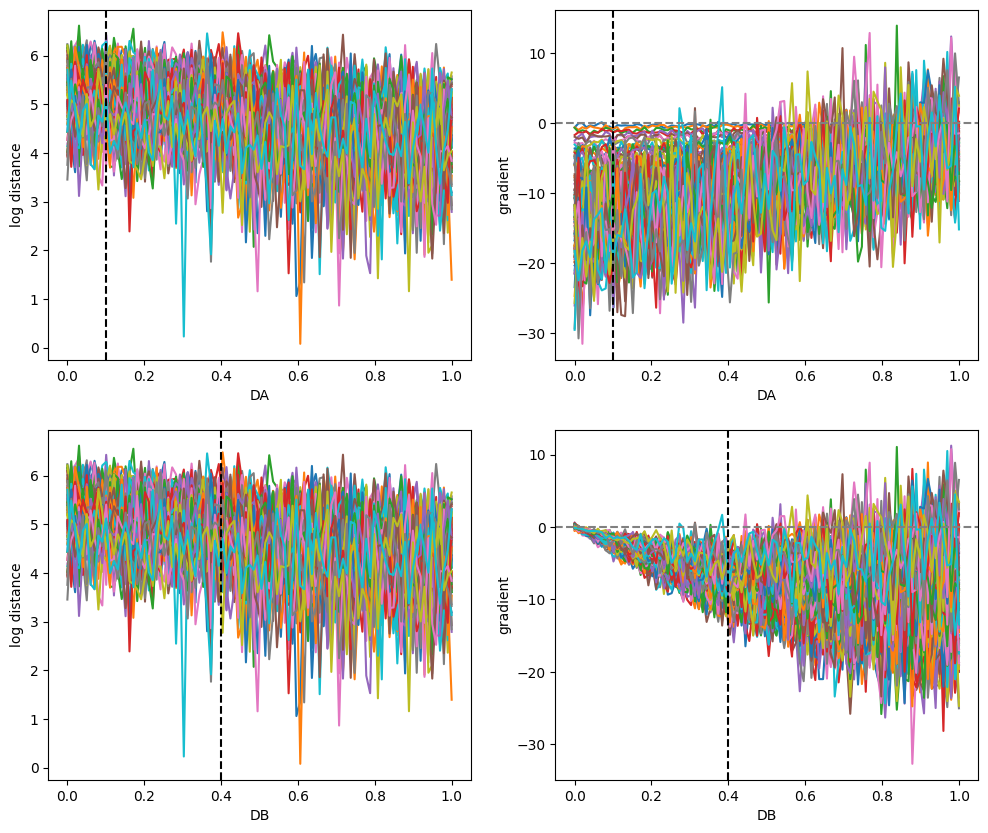

In [6]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
grads_k1 = np.array(grad_means_k1).reshape(100, 100)
grads_k1_bar = np.array(grad_means_k1_bar).reshape(100, 100)
for idx in range(100):
    axs[0,0].plot(k1_vals.cpu(), np.log(np.array(distances).reshape(100,100)[idx]))
    axs[0,1].plot(k1_vals.cpu(), grads_k1[idx])
    axs[1,0].plot(k1_bar_vals.cpu(), np.log(np.array(distances).reshape(100,100)[idx]))
    axs[1,1].plot(k1_bar_vals.cpu(), grads_k1_bar[idx])
axs[0,0].set(xlabel="DA", ylabel="log distance")
axs[0,1].set(xlabel="DA", ylabel="gradient")
axs[1,0].set(xlabel="DB", ylabel="log distance")
axs[1,1].set(xlabel="DB", ylabel="gradient")

axs[0,0].axvline(0.1, color='black', linestyle="--", label="original DA value")
axs[0,1].axhline(0., color='gray', linestyle="--", label="zero-gradient line")
axs[0,1].axvline(0.1, color='black', linestyle="--", label="original DA value")
axs[1,0].axvline(0.4, color='black', linestyle="--", label="original DB value")
axs[1,1].axvline(0.4, color='black', linestyle="--", label="original DB value")
axs[1,1].axhline(0., color='gray', linestyle="--", label="zero-gradient line")